In [4]:
# !pip install darts
# !pip install -U kaleido

## **Step 1: Import all the libraries and modules**

In [5]:
import pandas as pd
import numpy as np
import os
import sys

%load_ext autoreload
%autoreload 2
import  itertools
target_dir = os.path.abspath(os.path.join(os.getcwd(), '..' ))
sys.path.append(target_dir)
# from Models.ARIMAModel.preprocessing import preprocess_df_to_ts

from Models.ARIMAModel.preprocessing import preprocess_df_to_ts
from Models.ARIMAModel.plot import plot_auto_correlation_plot
from Models.ARIMAModel.plot import plot_partial_auto_correlation_plot
from Models.ARIMAModel.evaluation import load_model_sarima_model
from Models.ARIMAModel.evaluation import evaluation_of_model_sarima_Model
from Models.ARIMAModel.test import inspect_seasonality
from Models.ARIMAModel.ARIMA import train_arima_model
from darts.models.forecasting.arima import ARIMA


from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import  train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **Step 2 : Reading Data Daily Traffic Accident Forecasting**

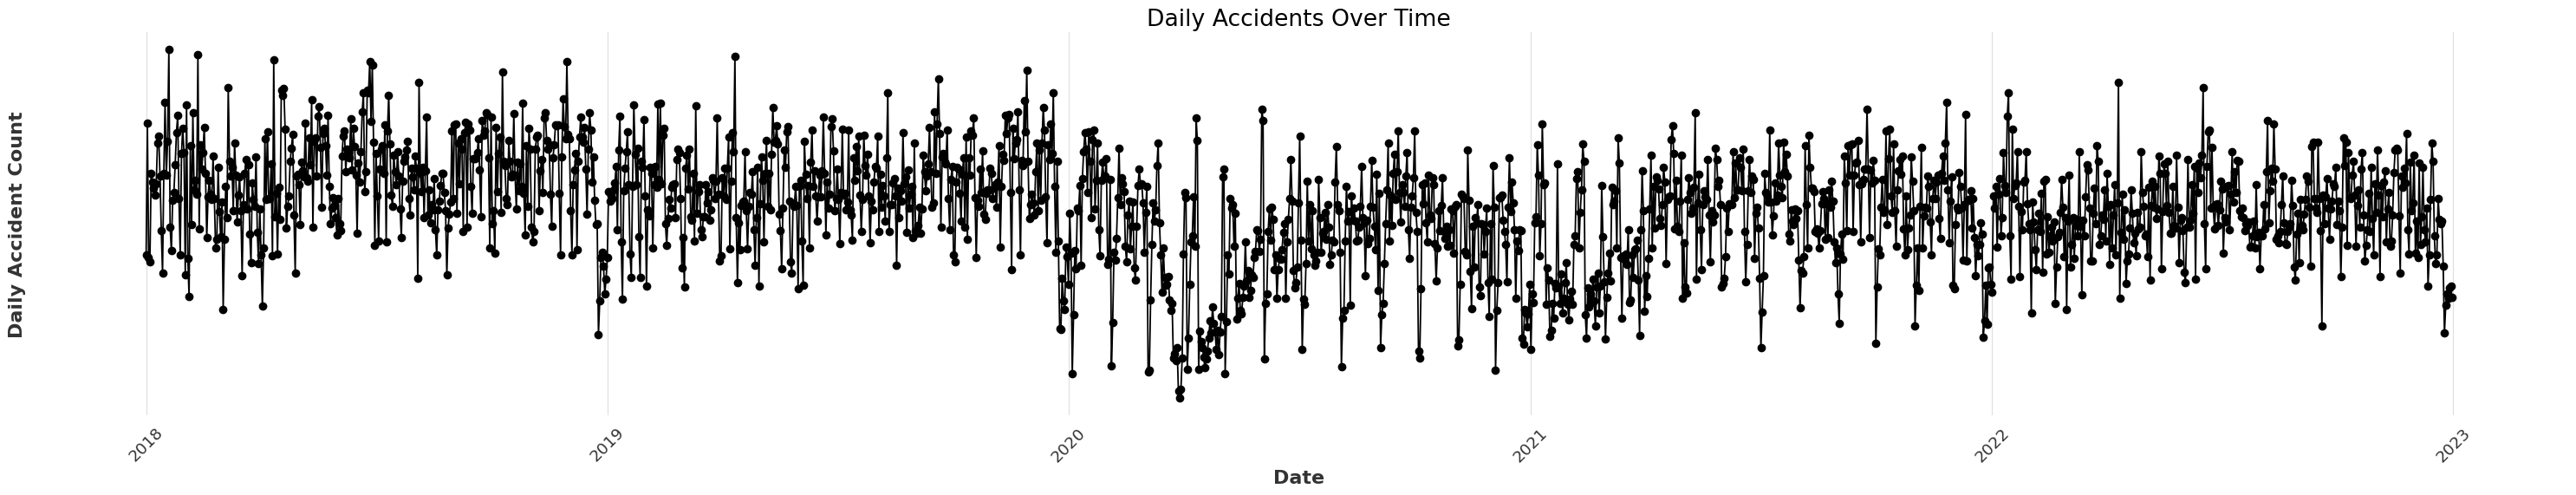

In [46]:
daily_traffic_accident_data_path = '../data/processed/daily_data.csv'
daily_accident_df = pd.read_csv(daily_traffic_accident_data_path)

daily_accidents_df = pd.DataFrame()
# Convert 'daily' column to datetime if it's not already in datetime format
daily_accidents_df['daily'] = pd.to_datetime(daily_accident_df['daily'])
daily_accidents_df['daily_accident'] = pd.to_datetime(daily_accident_df['daily_accident'])

# Set 'daily' column as index for time series plotting
daily_accidents_df.set_index('daily', inplace=True)
plt.rcParams.update({'font.size': 16})

# Plot
plt.figure(figsize=(30, 6))
plt.plot(daily_accidents_df.index, daily_accidents_df['daily_accident'], marker='o', linestyle='-')
plt.title('Daily Accidents Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Accident Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()




## **Step 3 : Split the Data into train and test data**

In [39]:
processed_train_df, processed_test_df = train_test_split(
        daily_accident_df, test_size=0.245, random_state=42, shuffle=False
    )


## **Step 4 : Preprocess the data into Time series object**

In [41]:
print('[INFO] Converting data into times series types')
ts_train = preprocess_df_to_ts(processed_train_df,'daily','daily_accident','1D')
ts_test = preprocess_df_to_ts(processed_test_df,'daily','daily_accident','1D')

[INFO] Converting data into times series types


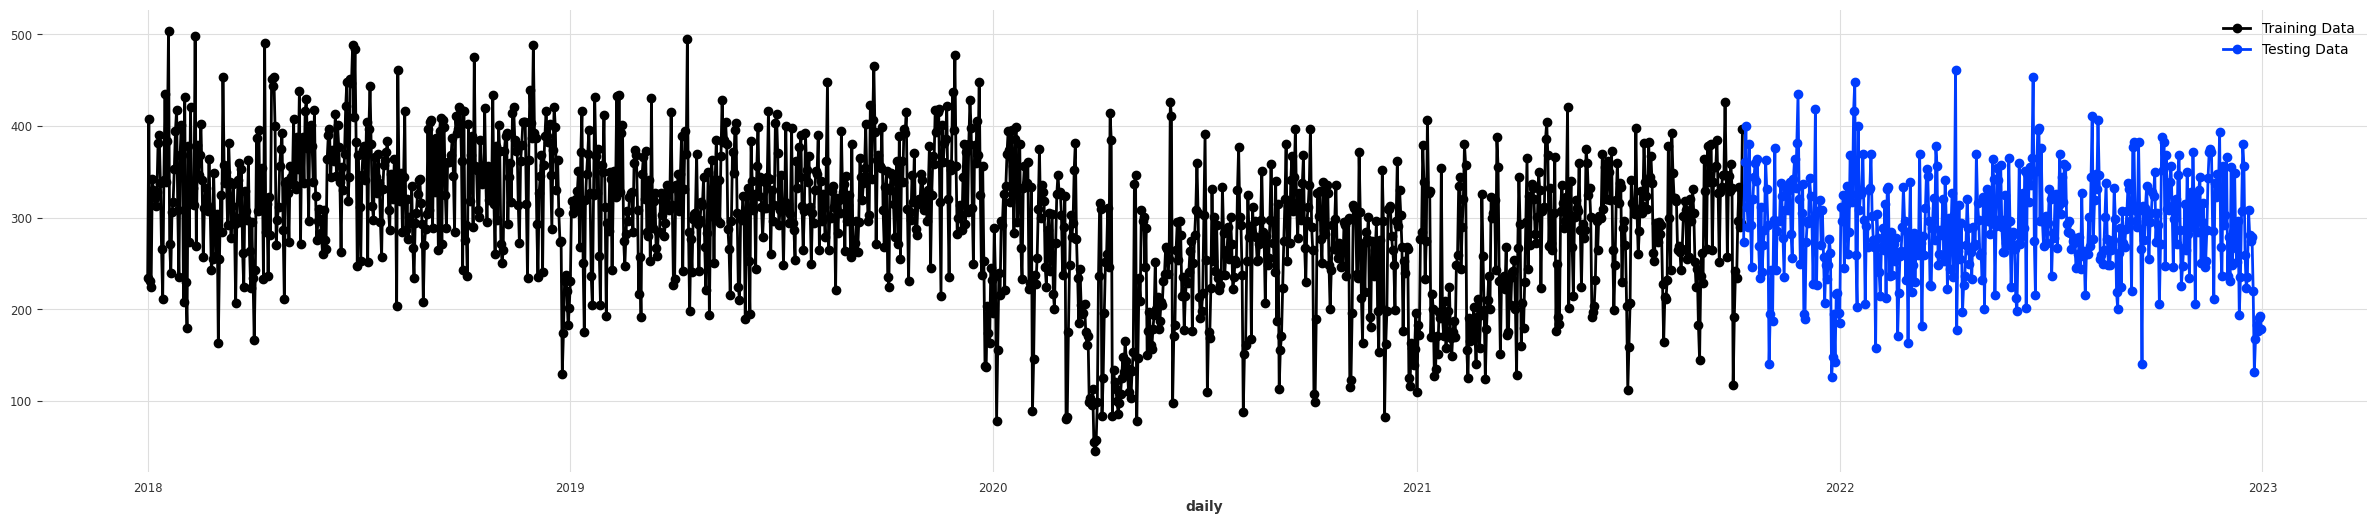

In [43]:
plt.figure(figsize=(30,6))
ts_train.plot(marker='o',label='Training Data')
ts_test.plot(marker='o',label='Testing Data')
plt.show()

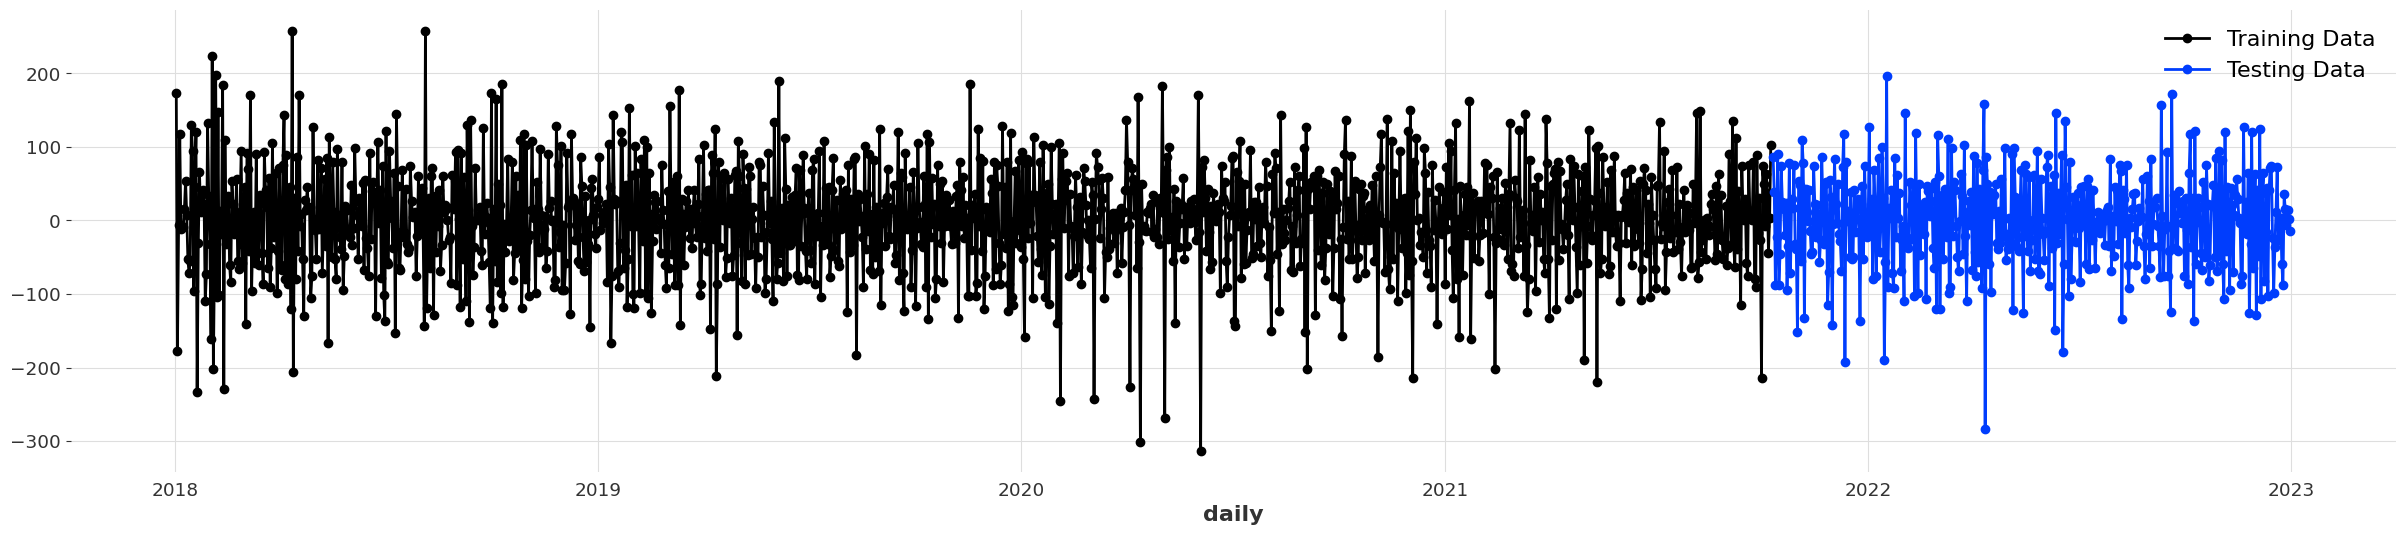

In [47]:
plt.figure(figsize=(30,6))
ts_train.diff(1).plot(marker='o',label='Training Data')
ts_test.diff(1).plot(marker='o',label='Testing Data')
plt.show()

## **Step 5 : Plot the Auto Correlation Plot**

[INFO] Plotting the auto correlation plot


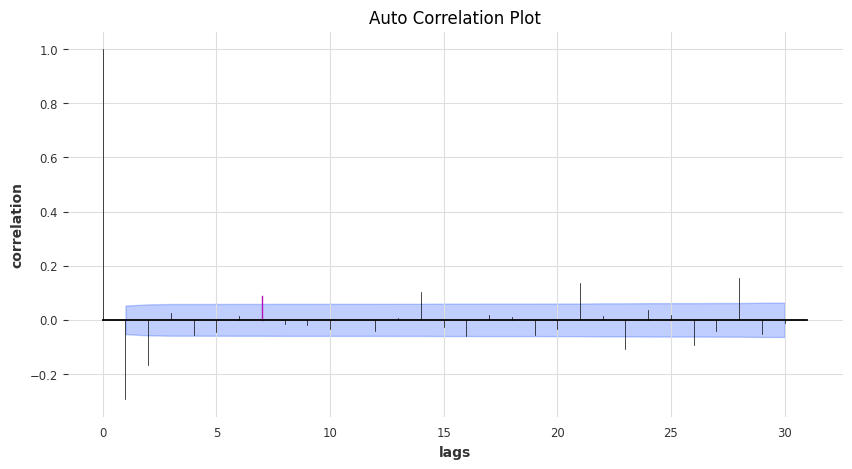

In [88]:
print('[INFO] Plotting the auto correlation plot')
plot_auto_correlation_plot(ts_train.diff(1), m=7, max_lag=30,saving_path='../Datasets_visualization')


## **Step 6 : Plot the Partial Auto Correlation Plot**

[INFO] Plotting the Partial auto correlation plot


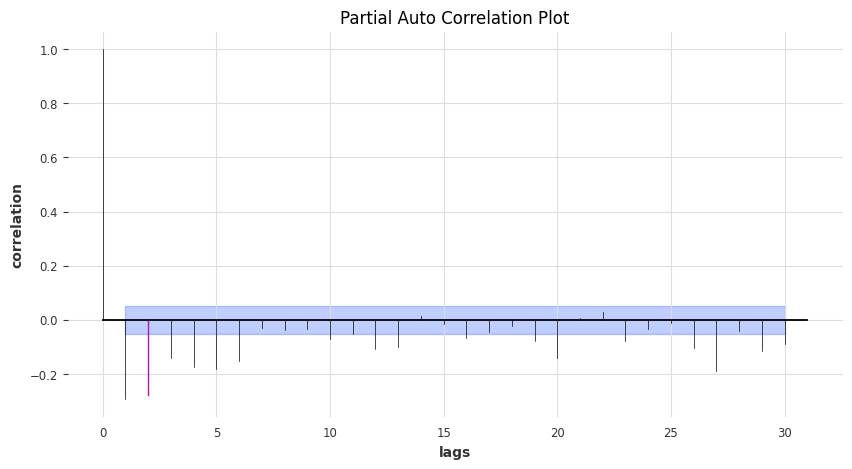

In [87]:
print('[INFO] Plotting the Partial auto correlation plot')
plot_partial_auto_correlation_plot(ts_train.diff(1), m=2, max_lag=30,saving_path='../Datasets_visualization')


## **Step 7 : Checkout the seasonality of training dataset**

In [63]:
print('[INFO] Seasonality in the training datasets')
inspect_seasonality(ts_train)

[INFO] Seasonality in the training datasets
There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 18.
There is seasonality of order 21.
There is seasonality of order : [7, 14, 18, 21]


[7, 14, 18, 21]

In [45]:
def adfuller_test(shot_count):
    # Perform the AD Fuller test
    result = adfuller(shot_count)

    # Print the test results
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))

    # Interpret the test results
    if result[1] <= 0.05:
        print(
            "strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


adfuller_test(daily_accident_df['daily_accident'])

ADF Test Statistic : -4.278158320451015
p-value : 0.00048453104111024223
#Lags Used : 23
Number of Observations Used : 1802
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [94]:
minimum_aicc = 0
best_aic = np.inf  # Initialize best AIC value to positive infinity
best_params = None  # Initialize best parameters to None
filename = daily_traffic_accident_data_path.split('/')[-1].split('.')[0]

parent_dir_for_saivng_trained_model_files = os.path.join("..","pkl")
os.makedirs(parent_dir_for_saivng_trained_model_files,exist_ok=True)



    # Load or initialize the list of trained model filenames
trained_model_filenames = []
trained_model_filenames_file = os.path.join(
    parent_dir_for_saivng_trained_model_files, "trained_model_filenames.txt"
)

if os.path.exists(trained_model_filenames_file):
    with open(trained_model_filenames_file, "r") as file:
        trained_model_filenames = file.read().splitlines()

p_values = [2, 3, 4]
d_values = [1,2]
q_values = [2, 3, 4]

P_values = [2, 3, 4]
D_values = [1]
Q_values = [2, 3, 4 ]
S_values = [7, 14, 18, 21]
# Define values for p, d, q, P, D, Q, and S



param_combinations = list(
    itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, S_values))
param_combinations_bar = tqdm(param_combinations, desc="Parameter combinations")

# Iterate through all combinations
for params in param_combinations_bar:
    p, d, q, P, D, Q, S = params
    print(f"Trying parameters: p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, S={S}")
    model_file_name = f'{filename}_param_p_{p}_d_{d}_q_{q}_P_{P}_D_{D}_Q_{Q}_S_{S}.pkl'
    # Construct the file path for the trained model
    trained_model_file_name = os.path.join(parent_dir_for_saivng_trained_model_files,model_file_name)
            
    # Skip if the file already exists or is in the list of trained model filenames
    if model_file_name in trained_model_filenames:
        print(f"Model for parameters {params} already trained, skipping...")
        continue

    try:

        arima = ARIMA(p=p, d=d, q=q,
                      seasonal_order=(P, D, Q, S),
                      trend=None,
                      random_state=None,
                      add_encoders=None)
        arima.fit(ts_train)
        aic = arima.model.aic
        
        trained_model_filenames.append(model_file_name)  # Add filename to the list
            # Append the filename to the text file
        with open(trained_model_filenames_file, "a") as file:
            file.write(model_file_name + "\n")
    
        # Check if current AIC value is lower than the best AIC value found so far
        if aic < best_aic:
            print(f"AIC for parameters {params}: {aic}")
            print(f'Best Parameters till now : {params}')
            best_aic = aic
            best_params = params
            arima.save(f'{trained_model_file_name}')
            
        
        # Horizon = len(testing_sc)
        # predictions = arima.predict(Horizon)
        # test_plot_visualization(predictions,
        #                         ts_train=train_series,
        #                         ts_test=testing_sc,
        #                         filename=params,
        #                         pollutant_name=selected_pair[0]['aqs_param'])
    except Exception as e:
        print(f'Error has occurred : {e}')
        continue
# Print the best parameters found
print(f"Best parameters based on AIC: {best_params}")


Parameter combinations:   0%|          | 0/648 [00:00<?, ?it/s]

Trying parameters: p=2, d=1, q=2, P=2, D=1, Q=2, S=7
Model for parameters (2, 1, 2, 2, 1, 2, 7) already trained, skipping...
Trying parameters: p=2, d=1, q=2, P=2, D=1, Q=2, S=14
Model for parameters (2, 1, 2, 2, 1, 2, 14) already trained, skipping...
Trying parameters: p=2, d=1, q=2, P=2, D=1, Q=2, S=18
Model for parameters (2, 1, 2, 2, 1, 2, 18) already trained, skipping...
Trying parameters: p=2, d=1, q=2, P=2, D=1, Q=2, S=21
Model for parameters (2, 1, 2, 2, 1, 2, 21) already trained, skipping...
Trying parameters: p=2, d=1, q=2, P=2, D=1, Q=3, S=7
Model for parameters (2, 1, 2, 2, 1, 3, 7) already trained, skipping...
Trying parameters: p=2, d=1, q=2, P=2, D=1, Q=3, S=14
Model for parameters (2, 1, 2, 2, 1, 3, 14) already trained, skipping...
Trying parameters: p=2, d=1, q=2, P=2, D=1, Q=3, S=18
AIC for parameters (2, 1, 2, 2, 1, 3, 18): 15099.608463511973
Best Parameters till now : (2, 1, 2, 2, 1, 3, 18)


Parameter combinations:   1%|          | 7/648 [09:33<14:35:41, 81.97s/it]

Trying parameters: p=2, d=1, q=2, P=2, D=1, Q=3, S=21


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AIC for parameters (2, 1, 2, 2, 1, 3, 21): 15016.752864420276
Best Parameters till now : (2, 1, 2, 2, 1, 3, 21)


Parameter combinations:   1%|          | 8/648 [19:15<29:37:25, 166.63s/it]

Trying parameters: p=2, d=1, q=2, P=2, D=1, Q=4, S=7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AIC for parameters (2, 1, 2, 2, 1, 4, 7): 14999.95142019365
Best Parameters till now : (2, 1, 2, 2, 1, 4, 7)


Parameter combinations:   1%|▏         | 9/648 [20:58<27:22:11, 154.20s/it]

Trying parameters: p=2, d=1, q=2, P=2, D=1, Q=4, S=14


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Parameter combinations:   2%|▏         | 10/648 [29:04<40:08:40, 226.52s/it]

Trying parameters: p=2, d=1, q=2, P=2, D=1, Q=4, S=18


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Parameter combinations:   2%|▏         | 11/648 [40:45<60:00:36, 339.15s/it]

Trying parameters: p=2, d=1, q=2, P=2, D=1, Q=4, S=21


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Parameter combinations:   2%|▏         | 12/648 [57:09<88:46:19, 502.48s/it]

Trying parameters: p=2, d=1, q=2, P=3, D=1, Q=2, S=7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Parameter combinations:   2%|▏         | 13/648 [58:09<67:54:19, 384.98s/it]

Trying parameters: p=2, d=1, q=2, P=3, D=1, Q=2, S=14
AIC for parameters (2, 1, 2, 3, 1, 2, 14): 14980.233143391059
Best Parameters till now : (2, 1, 2, 3, 1, 2, 14)


Parameter combinations:   2%|▏         | 14/648 [59:40<53:33:27, 304.11s/it]

Trying parameters: p=2, d=1, q=2, P=3, D=1, Q=2, S=18


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Parameter combinations:   2%|▏         | 15/648 [1:08:14<63:50:51, 363.12s/it]

Trying parameters: p=2, d=1, q=2, P=3, D=1, Q=2, S=21


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AIC for parameters (2, 1, 2, 3, 1, 2, 21): 14932.997753392818
Best Parameters till now : (2, 1, 2, 3, 1, 2, 21)


Parameter combinations:   2%|▏         | 16/648 [1:17:41<74:01:38, 421.67s/it]

Trying parameters: p=2, d=1, q=2, P=3, D=1, Q=3, S=7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Parameter combinations:   3%|▎         | 17/648 [1:18:41<55:29:57, 316.64s/it]

Trying parameters: p=2, d=1, q=2, P=3, D=1, Q=3, S=14


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Parameter combinations:   3%|▎         | 18/648 [1:20:54<45:59:02, 262.77s/it]

Trying parameters: p=2, d=1, q=2, P=3, D=1, Q=3, S=18


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Parameter combinations:   3%|▎         | 19/648 [1:29:12<58:01:57, 332.14s/it]

Trying parameters: p=2, d=1, q=2, P=3, D=1, Q=3, S=21


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Parameter combinations:   3%|▎         | 20/648 [1:40:00<74:17:30, 425.88s/it]

Trying parameters: p=2, d=1, q=2, P=3, D=1, Q=4, S=7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Parameter combinations:   3%|▎         | 21/648 [1:41:51<57:50:28, 332.10s/it]

Trying parameters: p=2, d=1, q=2, P=3, D=1, Q=4, S=14


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Parameter combinations:   3%|▎         | 22/648 [1:50:26<67:16:34, 386.89s/it]

Trying parameters: p=2, d=1, q=2, P=3, D=1, Q=4, S=18


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Parameter combinations:   4%|▎         | 23/648 [2:05:37<94:19:41, 543.33s/it]

Trying parameters: p=2, d=1, q=2, P=3, D=1, Q=4, S=21


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Parameter combinations:   4%|▎         | 24/648 [2:25:57<129:16:01, 745.77s/it]

Trying parameters: p=2, d=1, q=2, P=4, D=1, Q=2, S=7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Parameter combinations:   4%|▍         | 25/648 [2:27:19<94:42:17, 547.25s/it] 

Trying parameters: p=2, d=1, q=2, P=4, D=1, Q=2, S=14


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Parameter combinations:   4%|▍         | 26/648 [2:34:36<88:50:20, 514.18s/it]

Trying parameters: p=2, d=1, q=2, P=4, D=1, Q=2, S=18


Parameter combinations:   4%|▍         | 27/648 [2:42:50<87:36:36, 507.88s/it]

Trying parameters: p=2, d=1, q=2, P=4, D=1, Q=2, S=21
AIC for parameters (2, 1, 2, 4, 1, 2, 21): 14931.923142922285
Best Parameters till now : (2, 1, 2, 4, 1, 2, 21)


Parameter combinations:   4%|▍         | 28/648 [2:54:25<97:09:37, 564.16s/it]

Trying parameters: p=2, d=1, q=2, P=4, D=1, Q=3, S=7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Parameter combinations:   4%|▍         | 29/648 [2:55:57<72:37:46, 422.40s/it]

Trying parameters: p=2, d=1, q=2, P=4, D=1, Q=3, S=14


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Parameter combinations:   5%|▍         | 30/648 [3:04:30<77:12:40, 449.77s/it]

Trying parameters: p=2, d=1, q=2, P=4, D=1, Q=3, S=18


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Parameter combinations:   5%|▍         | 31/648 [3:16:46<91:46:31, 535.48s/it]

Trying parameters: p=2, d=1, q=2, P=4, D=1, Q=3, S=21


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Parameter combinations:   5%|▍         | 32/648 [3:32:31<112:39:59, 658.44s/it]

Trying parameters: p=2, d=1, q=2, P=4, D=1, Q=4, S=7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Parameter combinations:   5%|▌         | 33/648 [3:34:14<84:01:24, 491.84s/it] 

Trying parameters: p=2, d=1, q=2, P=4, D=1, Q=4, S=14


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Parameter combinations:   5%|▌         | 34/648 [3:44:06<88:59:48, 521.80s/it]

Trying parameters: p=2, d=1, q=2, P=4, D=1, Q=4, S=18


Parameter combinations:   5%|▌         | 34/648 [3:54:31<70:35:08, 413.86s/it]


KeyboardInterrupt: 

## **Step 9 : Training SARIMA Model**

In [72]:
best_params

(2, 1, 2, 2, 1, 2, 21)

In [83]:
import glob as gb
list_of_trained_best_models = gb.glob(f"{os.path.join('..','pkl')}/*.pkl")
list_of_trained_best_models

p, d, q, P, D, Q, S = 2,1,2,2,1,2,21
trained_model_file_name = f'../pkl/{filename}_param_p_{p}_d_{d}_q_{q}_P_{P}_D_{D}_Q_{Q}_S_{S}.pkl'

if trained_model_file_name in list_of_trained_best_models:
    print('Loading the pre-trained Model')
    model = ARIMA.load(trained_model_file_name)
    if model is not None:
        print(model.model.summary())
else:
    print('Training the Models')
    model = train_arima_model(ts_train, p, d, q, P, D, Q, S)
    model.save(trained_model_file_name)

    

Loading the pre-trained Model
                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                 1378
Model:             ARIMA(2, 1, 2)x(2, 1, 2, 21)   Log Likelihood               -7458.904
Date:                          Wed, 03 Apr 2024   AIC                          14935.808
Time:                                  16:22:59   BIC                          14982.718
Sample:                                       0   HQIC                         14953.372
                                         - 1378                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4881      0.205     -2.384      0.017      -0.889      -0.087
ar.L2          0.3505

In [82]:
# os.makedirs('../pkl',exist_ok=True)
# p, d, q, P, D, Q, S = 2,1,2,2,1,2,21
# trained_model_file_name = f'../pkl/SARIMAModel_param_p_{p}_d_{d}_q_{q}_P_{P}_D_{D}_Q_{Q}_S_{S}.pkl'
# arima_model = train_arima_model(ts_train, p, d, q, P, D, Q, S)
# arima_model.save(trained_model_file_name)


# import glob as gb

# list_of_trained_best_models = gb.glob(f'{trained_model_file_name}/*.pkl')

# for trained_model_file_name in list_of_trained_best_models:
#     print("Model file exists, load the existing ARIMA model")
#     arima = load_model_sarima_model(model_name=trained_model_file_name)
#     model = ARIMA.load(model_name)

#     # Print ARIMA model summary
#     if arima is not None:
#         print(arima.model.summary())
#     else:
#         print("ARIMA model is None, could not print summary.")
    




## **Step 10 : Loading the Trainined Model**

In [84]:
sarima_model = load_model_sarima_model(model_name=trained_model_file_name)


## **Step 11 : Evaluation of the SARIMA Model**

Evaluation of input window : 60 & Horizon : 388
metrics: {'MAE': 49.71, 'RMSE': 62.58, 'MAPE': 17.93, 'MSE': 3915.99}


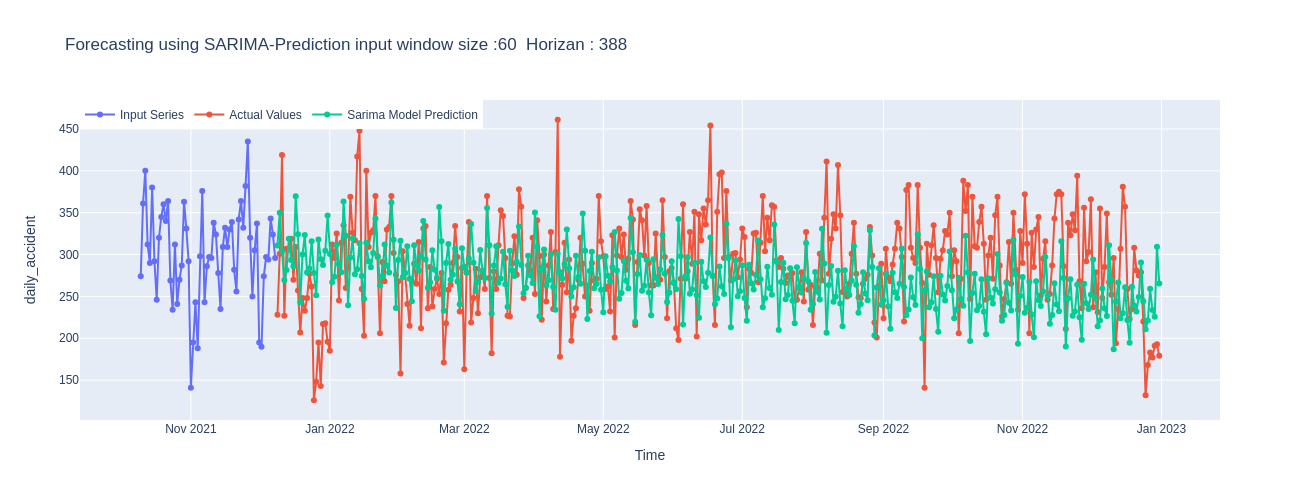

Evaluation of input window : 120 & Horizon : 328
metrics: {'MAE': 57.71, 'RMSE': 70.75, 'MAPE': 19.41, 'MSE': 5005.62}


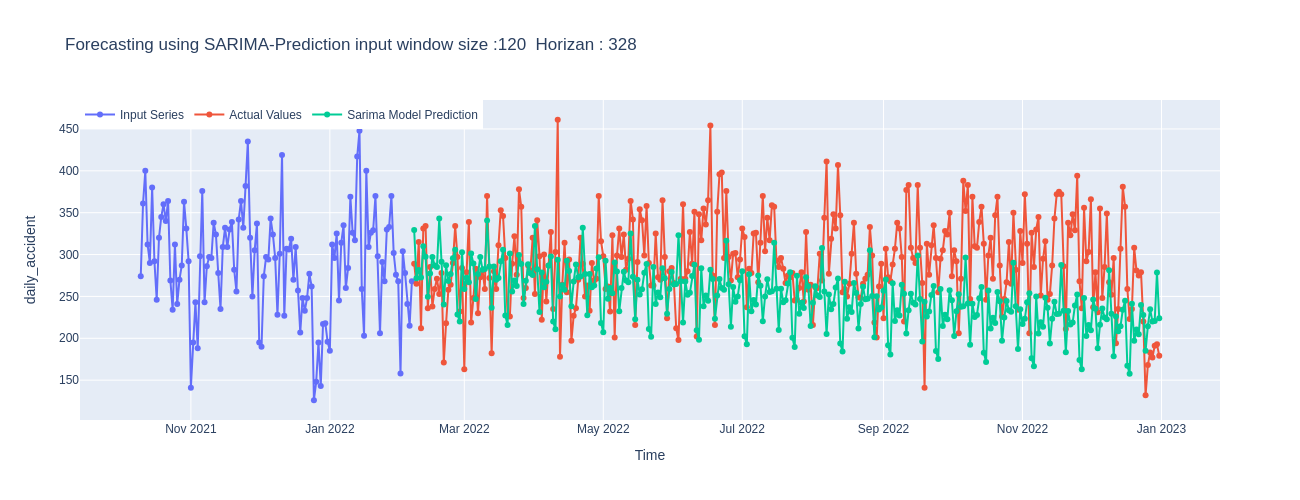

Evaluation of input window : 180 & Horizon : 268
metrics: {'MAE': 53.6, 'RMSE': 66.09, 'MAPE': 17.88, 'MSE': 4367.35}


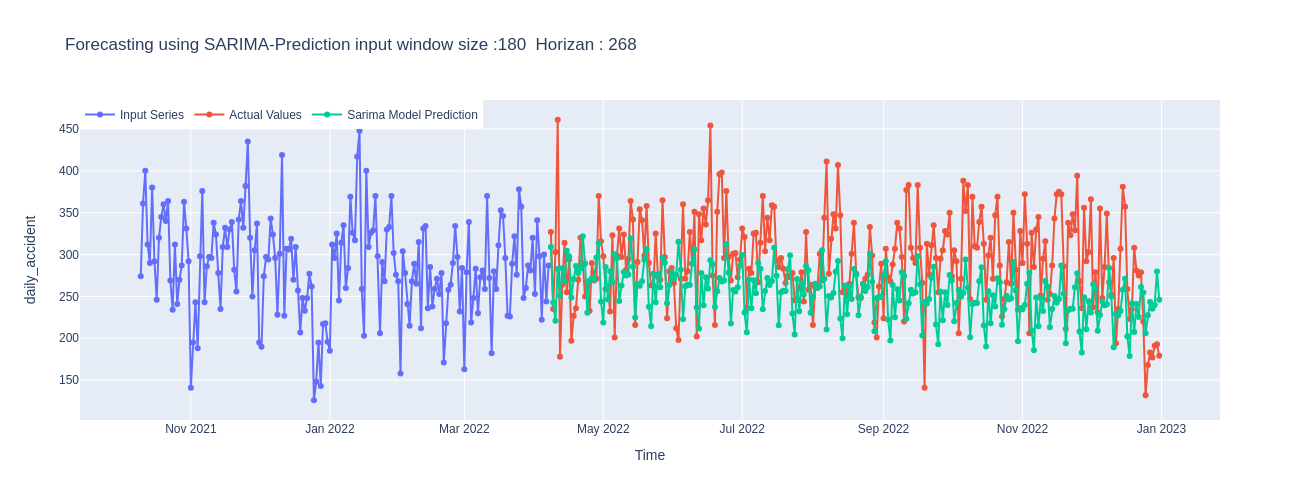

Evaluation of input window : 240 & Horizon : 208
metrics: {'MAE': 44.13, 'RMSE': 56.23, 'MAPE': 15.1, 'MSE': 3161.98}


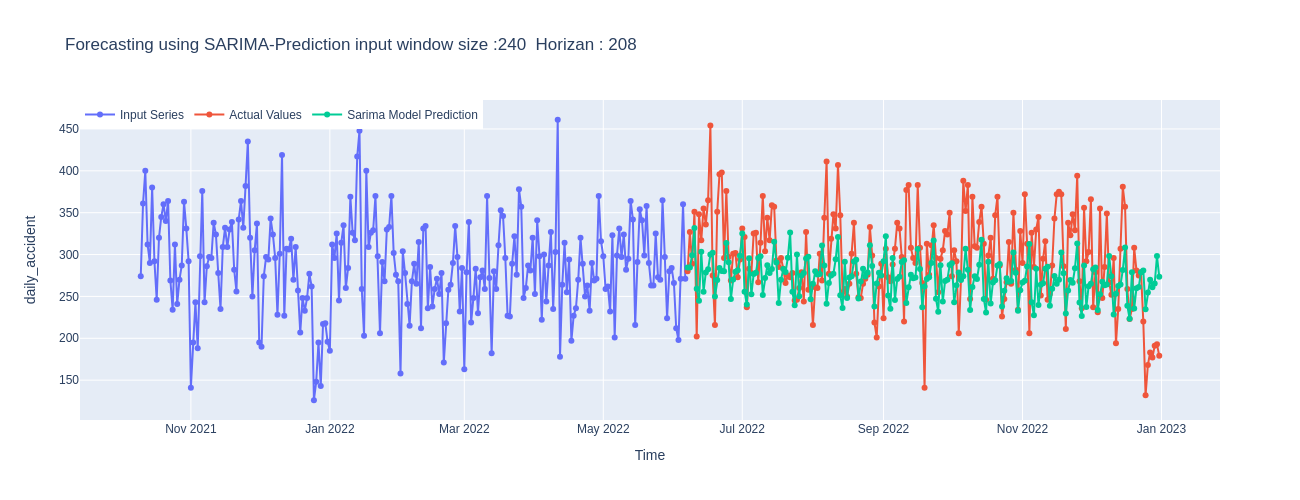

Evaluation of input window : 300 & Horizon : 148
metrics: {'MAE': 44.8, 'RMSE': 56.48, 'MAPE': 15.99, 'MSE': 3189.93}


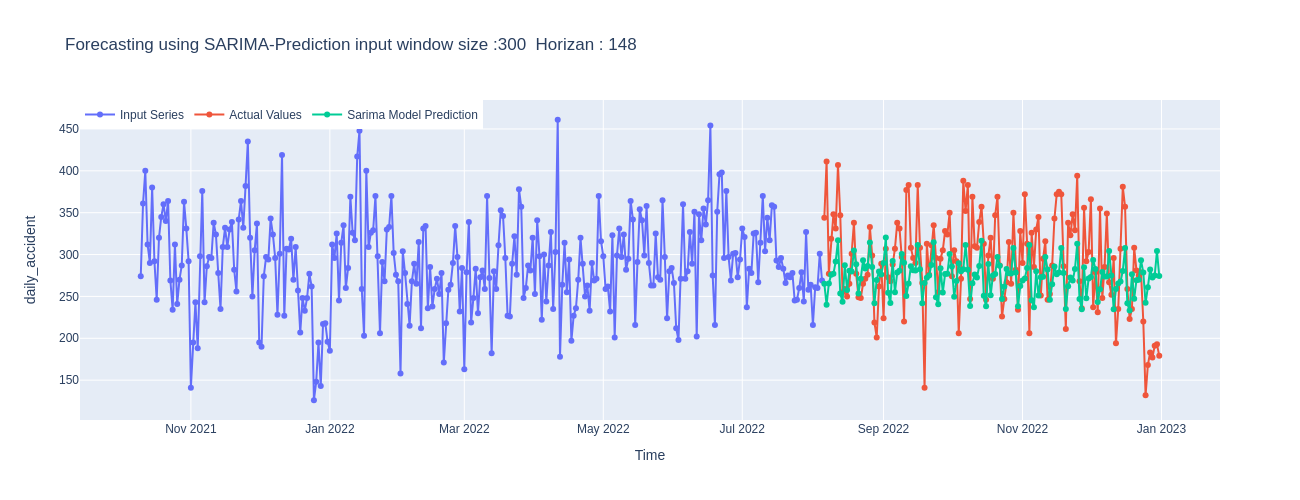

In [85]:
evaluation_sarima_df = evaluation_of_model_sarima_Model(trained_model_file_name,
                                                    ts_test=ts_test,
                                                    ts_train=ts_train)

## **Step 12 : Saving the Statistical Results**

In [92]:
statistical_result_save_path = os.path.join("../StatisticalResults")
os.makedirs(statistical_result_save_path,exist_ok=True)
evaluation_sarima_df.to_csv(
    f"{statistical_result_save_path}/sarima_evaluation_results.csv", index=False
)


In [93]:
evaluation_sarima_df

,input_window_in_hours,output_window_in_hours,MAE,RMSE,MAPE,MSE
0,60,388,49.71,62.58,17.93,3915.99
1,120,328,57.71,70.75,19.41,5005.62
2,180,268,53.60,66.09,17.88,4367.35
3,240,208,44.13,56.23,15.10,3161.98
4,300,148,44.80,56.48,15.99,3189.93


In [47]:
len(ts_test)/30

14.933333333333334